Here we'll try very hard to overfit, by using silly models.

This notebook should be run after the preprocessing part in dogs_vs_cats_with_AlexNet has already been run.

In [19]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import bcolz
import numpy as np
import pandas as pd
import os

In [2]:
import theano
import keras

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


In [3]:
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.layers.core import Layer
from keras.layers import merge
from keras.callbacks import CSVLogger

In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH = 227, 227

### First, let's do a simple linear model. It should have enough parameters to learn all the images and overfit!

In [5]:
def load_array(fname):
    return bcolz.open(fname)[:]

img_mean = load_array('input/img_mean.bz')

def center(img):
    return img - img_mean.astype(np.float32).transpose([2,0,1])

In [9]:
linear = Sequential([
    Lambda(center, input_shape=(3, IMAGE_HEIGHT, IMAGE_WIDTH), output_shape=(3, IMAGE_HEIGHT, IMAGE_WIDTH)),
    Flatten(),
    Dense(2, activation='softmax')
])

In [10]:
linear.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 3, 227, 227)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 154587)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 309176    
Total params: 309,176
Trainable params: 309,176
Non-trainable params: 0
_________________________________________________________________


309k parameters for 23k images. It shouldn't be too hard to learn them all...

In [6]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [7]:
def fit_model(model, batches, val_batches, nb_epoch=1, verbose=1, callbacks=None):
    model.fit_generator(batches, batches.n//batches.batch_size, epochs=nb_epoch, callbacks=callbacks,
                        validation_data=val_batches, validation_steps=val_batches.n//val_batches.batch_size, verbose=verbose)

In [8]:
train_path = 'input/train'
valid_path = 'input/valid'
test_path = 'input/test'

In [17]:
batches = get_batches(train_path, batch_size=2000)
val_batches = get_batches(valid_path, batch_size=2000)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [18]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
linear.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
csv_logger = CSVLogger('training_linear.log')

In [19]:
# valid_batches and batches are wrongly named - inverted...
fit_model(linear, batches, val_batches, nb_epoch=20, callbacks=[csv_logger], verbose=1)

Epoch 1/20
11/11 [==============================] - 74s - loss: 7.7969 - acc: 0.5147 - val_loss: 7.8092 - val_acc: 0.5155
Epoch 2/20
11/11 [==============================] - 57s - loss: 7.6748 - acc: 0.5238 - val_loss: 7.8737 - val_acc: 0.5115
Epoch 3/20
11/11 [==============================] - 56s - loss: 7.7165 - acc: 0.5212 - val_loss: 7.9059 - val_acc: 0.5095
Epoch 4/20
11/11 [==============================] - 61s - loss: 7.7335 - acc: 0.5202 - val_loss: 7.9623 - val_acc: 0.5060
Epoch 5/20
11/11 [==============================] - 57s - loss: 7.7406 - acc: 0.5198 - val_loss: 7.9704 - val_acc: 0.5055
Epoch 6/20
11/11 [==============================] - 57s - loss: 7.6817 - acc: 0.5234 - val_loss: 7.9059 - val_acc: 0.5095
Epoch 7/20
11/11 [==============================] - 56s - loss: 7.8698 - acc: 0.5117 - val_loss: 7.9301 - val_acc: 0.5080
Epoch 8/20
11/11 [==============================] - 55s - loss: 7.6661 - acc: 0.5244 - val_loss: 7.9865 - val_acc: 0.5045
Epoch 9/20
11/11 [======

In [23]:
training_results = pd.read_csv('training_linear.log')

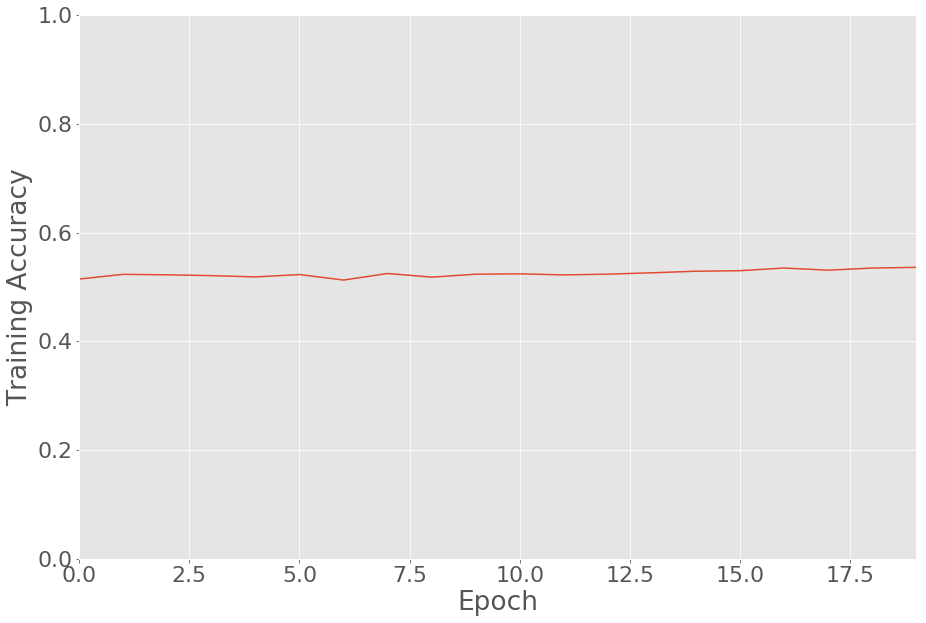

In [24]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

training_results['acc'].plot(figsize=(15,10))
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')

# At least this seemed to learn something...
Still, one would expect overfit (even more since the batch size is very big compared to the total amount of images), which never happens.

# Add one more layer, hence more parameters...
Also, let's be more aggressive, train only on the validation dataset (that has 2000 elements), to stimulate even more overfitting...

In [9]:
two_layers = Sequential([
    Lambda(center, input_shape=(3, IMAGE_HEIGHT, IMAGE_WIDTH), output_shape=(3, IMAGE_HEIGHT, IMAGE_WIDTH)),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(2, activation='softmax')
])

In [25]:
two_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 3, 227, 227)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 154587)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               77294000  
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1002      
Total params: 77,295,002
Trainable params: 77,295,002
Non-trainable params: 0
_________________________________________________________________


In [22]:
sgd5 = SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
two_layers.compile(optimizer=sgd5, loss='categorical_crossentropy', metrics=['accuracy'])
csv_logger = CSVLogger('training_two_layers.log')

In [26]:
small_batches = get_batches(valid_path, batch_size=64)

Found 2000 images belonging to 2 classes.


In [27]:
two_layers.fit_generator(small_batches, small_batches.n//small_batches.batch_size, epochs=20, callbacks = [csv_logger])

Epoch 1/20
31/31 [==============================] - 8s - loss: 8.0442 - acc: 0.5005     
Epoch 2/20
31/31 [==============================] - 8s - loss: 8.0118 - acc: 0.5029     
Epoch 3/20
31/31 [==============================] - 8s - loss: 8.0761 - acc: 0.4989     
Epoch 4/20
31/31 [==============================] - 8s - loss: 8.0257 - acc: 0.5021     
Epoch 5/20
31/31 [==============================] - 8s - loss: 8.1721 - acc: 0.4930     
Epoch 6/20
31/31 [==============================] - 8s - loss: 8.0200 - acc: 0.5024     
Epoch 7/20
31/31 [==============================] - 7s - loss: 7.8190 - acc: 0.5149     
Epoch 8/20
31/31 [==============================] - 8s - loss: 8.1175 - acc: 0.4964     
Epoch 9/20
31/31 [==============================] - 8s - loss: 7.9859 - acc: 0.5045     
Epoch 10/20
31/31 [==============================] - 8s - loss: 7.9534 - acc: 0.5066     
Epoch 11/20
31/31 [==============================] - 8s - loss: 8.1372 - acc: 0.4951     
Epoch 12/20
31/31 [

In [37]:
small_batches = get_batches(valid_path, batch_size=256)

Found 2000 images belonging to 2 classes.


In [29]:
two_layers.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
two_layers.fit_generator(small_batches, small_batches.n//small_batches.batch_size, epochs=20,
                         callbacks = [CSVLogger('training_two_layers_part_two.log')])

Epoch 1/20
7/7 [==============================] - 6s - loss: 8.0231 - acc: 0.5022     
Epoch 2/20
7/7 [==============================] - 6s - loss: 8.1927 - acc: 0.4917     
Epoch 3/20
7/7 [==============================] - 6s - loss: 7.8838 - acc: 0.5109     
Epoch 4/20
7/7 [==============================] - 6s - loss: 8.3515 - acc: 0.4819     
Epoch 5/20
7/7 [==============================] - 6s - loss: 7.6692 - acc: 0.5242     
Epoch 6/20
7/7 [==============================] - 6s - loss: 8.1295 - acc: 0.4956     
Epoch 7/20
7/7 [==============================] - 6s - loss: 8.1115 - acc: 0.4967     
Epoch 8/20
7/7 [==============================] - 6s - loss: 8.1312 - acc: 0.4955     
Epoch 9/20
7/7 [==============================] - 6s - loss: 8.0770 - acc: 0.4989     
Epoch 10/20
7/7 [==============================] - 6s - loss: 8.0464 - acc: 0.5008     
Epoch 11/20
7/7 [==============================] - 6s - loss: 8.1023 - acc: 0.4973     
Epoch 12/20
7/7 [========================

#### For some reason, needs a restart. Save and reload weights...

In [54]:
w1 = two_layers.layers[2].get_weights()[0]
b1 = two_layers.layers[2].get_weights()[1]
w2 = two_layers.layers[3].get_weights()[0]
b2 = two_layers.layers[3].get_weights()[1]

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
    
def create_dir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    
create_dir('model_weights')
    
save_array('model_weights/w1.bz', w1)
save_array('model_weights/b1.bz', b1)
save_array('model_weights/w2.bz', w2)
save_array('model_weights/b2.bz', b2)

In [11]:
w1 = load_array('model_weights/w1.bz')
b1 = load_array('model_weights/b1.bz')
w2 = load_array('model_weights/w2.bz')
b2 = load_array('model_weights/b2.bz')

two_layers.layers[2].set_weights((w1, b1))
two_layers.layers[3].set_weights((w2, b2))

In [12]:
small_batches = get_batches(valid_path, batch_size=500)
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
two_layers.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Found 2000 images belonging to 2 classes.


In [13]:
two_layers.fit_generator(small_batches, small_batches.n//small_batches.batch_size, epochs=200,
                         callbacks = [CSVLogger('training_two_layers_part_three.log')])

Epoch 1/200
4/4 [==============================] - 5s - loss: 8.0590 - acc: 0.5000     
Epoch 2/200
4/4 [==============================] - 6s - loss: 8.0590 - acc: 0.5000     
Epoch 3/200
4/4 [==============================] - 6s - loss: 8.0590 - acc: 0.5000     
Epoch 4/200
4/4 [==============================] - 6s - loss: 8.0590 - acc: 0.5000     
Epoch 5/200
4/4 [==============================] - 6s - loss: 8.0590 - acc: 0.5000     
Epoch 6/200
4/4 [==============================] - 6s - loss: 8.0590 - acc: 0.5000     
Epoch 7/200
4/4 [==============================] - 6s - loss: 8.0590 - acc: 0.5000     
Epoch 8/200
4/4 [==============================] - 6s - loss: 8.0590 - acc: 0.5000     
Epoch 9/200
4/4 [==============================] - 6s - loss: 8.0590 - acc: 0.5000     
Epoch 10/200
4/4 [==============================] - 6s - loss: 8.0590 - acc: 0.5000     
Epoch 11/200
4/4 [==============================] - 6s - loss: 8.0590 - acc: 0.5000     
Epoch 12/200
4/4 [============

KeyboardInterrupt: 

In [16]:
training_results = pd.concat((
    pd.read_csv('training_two_layers.log'), pd.read_csv('training_two_layers_part_two.log'), pd.read_csv('training_two_layers_part_three.log')
)).reset_index(drop=True)

In [17]:
print(training_results.shape)
training_results.head()

(62, 3)


,epoch,acc,loss
0,0,0.500504,8.044167
1,1,0.500000,8.059048
2,2,0.497417,8.100675
3,3,0.503616,8.000770
4,4,0.494318,8.150628


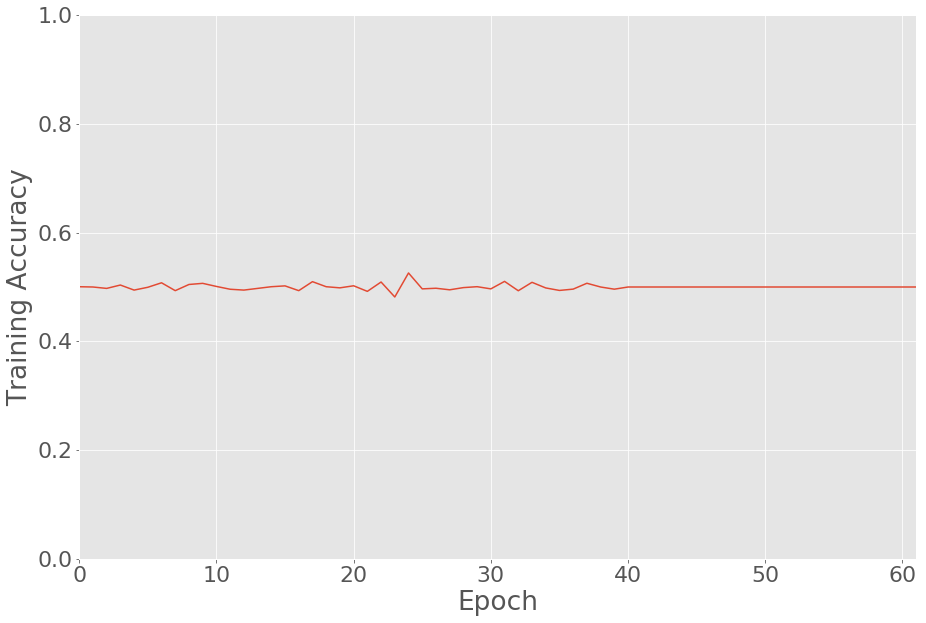

In [22]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

training_results['acc'].plot(figsize=(15,10))
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')